### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time



from diabetes_onset_plotter import survival_fit_res, make_results

In [3]:
np.random.seed(seed = 0)

### Load Data

In [4]:
%%time
p = '../tempPropSelection/'
treated = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 229 ms, sys: 129 ms, total: 358 ms
Wall time: 376 ms


### Optional(filter registrations after  a particular month and before a particular month)

In [5]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [6]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}
#put title in the figures 1 0 no
outcome_title = 1

kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [7]:
path_tabs = './res/tabs/'
path_figs = './res/figs/'
path_figs2 = './res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [8]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Treatment']

### Diabetes

In [9]:
#treated[treated.PERS_ID == '2567120'][['MYR', 'ALLOW_IP', 'ALLOW_ER', 'Acute-bin']]

In [10]:
#survTr

In [11]:
%%time
after = 0
grace = 0
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes, after = after, grace = grace).reset_index(drop = True)


CPU times: user 13.1 s, sys: 52.1 ms, total: 13.2 s
Wall time: 13.2 s


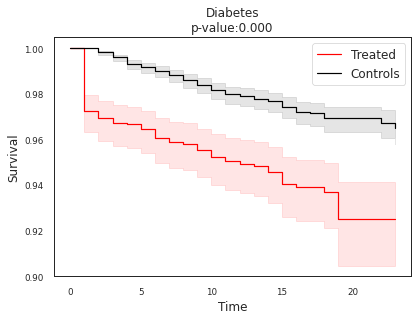

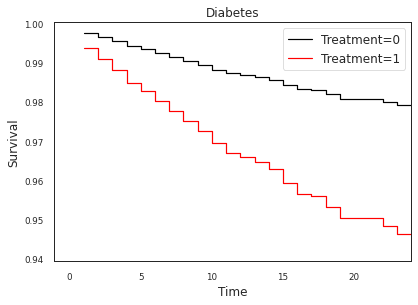

In [12]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                     outcome_title = outcome_title)

In [13]:
lrsumm

test_statistic             p   -log2(p)
Diabetes       54.495451  1.558081e-13  42.545295

In [14]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                  1.843           0.512        3.598    0.000
Gender               0.313           0.149        2.103    0.035
Total Cost           0.020           0.026        0.754    0.451
Tobacco use         -0.112           0.242       -0.462    0.644
Obesity              0.571           0.140        4.074    0.000
Hypertension        -0.007           0.161       -0.041    0.967
Hypothyroid         -0.035           0.206       -0.169    0.866
Disease Count        1.386           0.598        2.318    0.020
Treatment            0.967           0.138        7.011    0.000

### ER

In [15]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [16]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes,after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 13.3 s, sys: 43.7 ms, total: 13.3 s
Wall time: 13.3 s


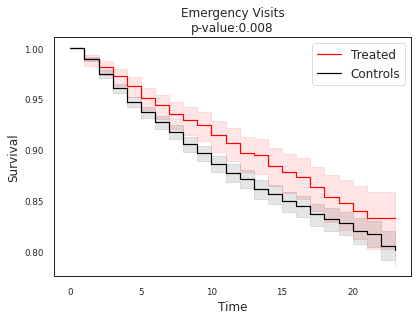

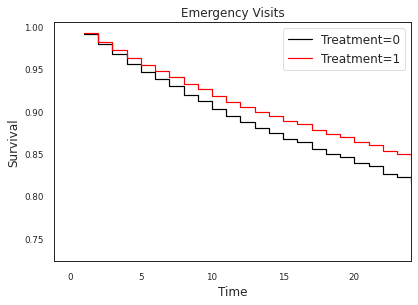

In [17]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Emergency Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [18]:
lrsumm

test_statistic         p  -log2(p)
Emergency Visits        7.122242  0.007613  7.037254

In [19]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -2.257           0.213      -10.594    0.000
Gender               0.100           0.073        1.368    0.171
Total Cost           0.052           0.012        4.234    0.000
Tobacco use          0.337           0.090        3.750    0.000
Obesity             -0.273           0.067       -4.065    0.000
Hypertension         0.000           0.080        0.006    0.995
Hypothyroid         -0.069           0.104       -0.665    0.506
Disease Count        2.863           0.264       10.823    0.000
Treatment           -0.183           0.084       -2.181    0.029

### IP

In [20]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [21]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes,after = after,  onset = onset, grace = grace).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 13.4 s, sys: 32.6 ms, total: 13.4 s
Wall time: 13.4 s


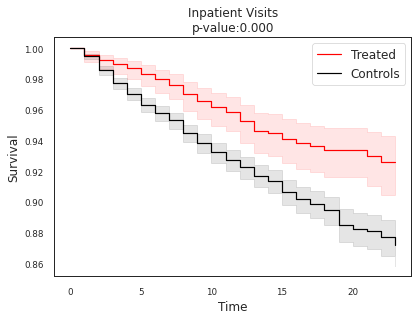

In [22]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Inpatient Visits'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline,
                                      outcome_title = outcome_title)

In [23]:
lrsumm

test_statistic         p   -log2(p)
Inpatient Visits       17.068893  0.000036  14.759724

In [24]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -0.915           0.274       -3.341    0.001
Gender              -0.246           0.104       -2.358    0.018
Total Cost           0.199           0.019       10.610    0.000
Tobacco use          0.197           0.118        1.669    0.095
Obesity             -0.200           0.086       -2.340    0.019
Hypertension        -0.070           0.102       -0.688    0.491
Hypothyroid         -0.238           0.128       -1.858    0.063
Disease Count        2.729           0.319        8.563    0.000
Treatment           -0.510           0.119       -4.286    0.000

### Acute Care IP OR ER

In [25]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [26]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, after = after, onset = onset, grace = grace).reset_index(drop = True)


CPU times: user 13.2 s, sys: 20.6 ms, total: 13.3 s
Wall time: 13.3 s


In [27]:
treated[treated.PERS_ID == '2582630'][['IP_BIN2','ER_BIN2']]

Empty DataFrame
Columns: [IP_BIN2, ER_BIN2]
Index: []

In [28]:
survTr[survTr.E >0]

PERS_ID   T  E  ACUTE  ACUTE2  ACUTE6  ACUTE_C  AGE_AT_MIDMONTH  \
4     2619378   3  1      0     0.0     0.0        1               78   
5     2621187  11  1      0     0.0     0.0        2               78   
17    2651688   4  1      0     0.0     0.0        0               74   
28    2668219   5  1      0     0.0     0.0        0               71   
31    2674753   3  1      0     0.0     0.0        0               71   
...       ...  .. ..    ...     ...     ...      ...              ...   
1536  5003200   1  1      1     1.0     1.0        1               55   
1545  5010677  16  1      0     0.0     0.0        0               39   
1550  5014675   3  1      0     0.0     0.0        1               26   
1563  5021778   1  1      1     1.0     1.0        1               24   
1574  5028397   2  1      0     0.0     0.0        0               39   

      ALLOW_AMT  ALLOW_ER  ...  IP_BIN  IP_BIN2  IP_BIN6  IP_C  LOB  MBR_GNDR  \
4           399       0.0  ...       0      0.0      0.0     0    1         1   
5         13007       0.0  ...       0      0.0      0.0     0    1         1   
17          179       0.0  ...       0      0.0      0.0     0    1         1   
28          346       0.0  ...       0      0.0      0.0     0    1         0   
31          207       0.0  ...       0      0.0      0.0     0    1         0   
...         ...       ...  ...     ...      ...      ...   ...  ...       ...   
1536       3137    1298.0  ...       0      0.0      0.0     0    1         0   
1545          0       0.0  ...       0      0.0      0.0     0    1         0   
1550        409       0.0  ...       0      0.0      0.0     0    1         0   
1563      20355    1161.0  ...       0      0.0      0.0     0    1         0   
1574          0       0.0  ...       0      0.0      0.0     0    1         0   

      MEDICAID_LOB     MYR  PREGNANCY  Treatment  
4         Medicare  201910        0.0          1  
5         Medicare  202001        0.0          1  
17        Medicare  202011        0.0          1  
28        Medicare  201911        0.0          1  
31        Medicare  202004        0.0          1  
...            ...     ...        ...        ...  
1536    Commercial  202005        0.0          1  
1545    Commercial  202001        0.0          1  
1550    Commercial  202010        0.0          1  
1563    Commercial  202007        0.0          1  
1574    Commercial  202005        0.0          1  

[220 rows x 94 columns]

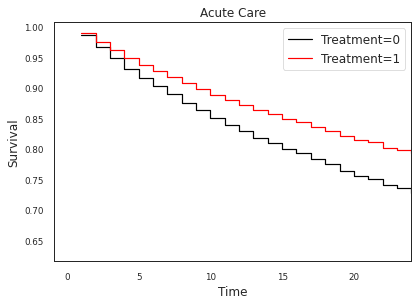

In [29]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute Care'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline,
                                      outcome_title = outcome_title)

In [30]:
lrsumm

test_statistic         p  -log2(p)
Acute Care       18.704594  0.000015  15.99975

In [31]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                 -1.867           0.182      -10.239    0.000
Gender              -0.023           0.064       -0.353    0.724
Total Cost           0.103           0.011        9.275    0.000
Tobacco use          0.265           0.079        3.347    0.001
Obesity             -0.227           0.057       -3.961    0.000
Hypertension        -0.015           0.068       -0.224    0.822
Hypothyroid         -0.178           0.090       -1.981    0.048
Disease Count        2.639           0.227       11.620    0.000
Treatment           -0.311           0.074       -4.227    0.000

### Load all Log Rank Sums in a matrix

In [32]:
from pathlib import Path
p = Path('./res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('./res/tabs/all_logrank.csv')


In [33]:
df2

logRank statistic       p-value  RMST difference
Diabetes                  54.495451  1.558081e-13        -0.749468
Emergency Visits           7.122242  7.613346e-03         0.495013
Inpatient Vistis          17.068893  3.604794e-05         0.705059
Acute Care                18.704594  1.526143e-05         1.011306